The key is to train a cnn to separate the content from the style of an image. Then we can merge the content of one image with the style of the other.

As we train a cnn, the max pooling layers discard detailed spatial information which is irrelevant for classification. As we go deeper into the network the input image is transformed into feature maps that increasingly care more about the content of the image rather than other details such as texture and colors. Later layers are often refered to as content representation of the image. The content representation is taken as the output of one of the convo layers.
The content loss measures how far away the content representation is far from the target content. The goal is to change the target image so that its content representation matches the content image. We are not training the CNN. 

We are using the VGG as a feature extractor

To make sure that the target content matches the image content we use the content loss

To isolate only the style a feature space designed to caputre texture and color info is used. For each feature map we can measure how strongly each detected feature relates to other features in other feature maps. 

Style representation looks in correlations between the feautres in individual layers of the vgg (how similar the features in a single layer are). By including the correlations between multiple layers of different sizes we can get a multi layer style representation of the input image; one that captures large and small style features. 

The correlation in each layer are given by a gram matrix:
- vectorize the values so that it can be seen by an MLP (flattening)
- multiply the result by its transpose.
- the result is a matrix whose values indicate the similarities between the layers
    
To calc the style loss between the target and the image we calc the mean squared distance between the style and the gram matrices for each layer in the predifined list (from the convo layers)

Finally add the losses to get the total loss
Use back propagation and optimization do decrease the loss and get the target image to match the desired content and style

Finally, we have values for the content and style losses but because they are calculated different, they will look very different. THE GOAL IS FOR THE TARGET IMAGE TO TAKE THEM BOTH EQUALLY. So we apply weights to these losses (alpha and beta); this means multiplying the style loss by a larger value than the content loss.
In the ratio alpha/beta change beta. As you increase beta, we lose more content and more style is rep in the image

In [1]:
import numpy as np 
import torch

import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image
import matplotlib.image as mpimg


from torchvision import transforms, models
import torch.optim as optim

In [2]:
vgg = models.vgg19(pretrained=True).features

In [3]:
# freeze vgg parameters since we are only optimizing the target

for param in vgg.parameters():
    param.requires_grad_(False)

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
# passing the model to cuda
vgg.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [6]:
content = Image.open('dog.jpg')
style = Image.open('painting.jpg')

In [7]:
# 
def load_image(img_path, size=(400, 592)):
    
    image = Image.open(img_path)
    
    transform = transforms.Compose([transforms.Resize(size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5,),(0.5,))])
    
    # CNN expects a tensor with the shape (batch_size, d, w, h)
    image = transform(image).unsqueeze(0)
    
    return image

In [8]:
def im_convert(tensor):
    
    image = tensor.to('cpu').clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image*np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
    image = image.clip(0,1)
    
    return image

In [9]:
content = load_image('dog.jpg').to(device)
style = load_image('painting.jpg').to(device)

In [10]:
layers = {'0': 'conv1_1',
         '5': 'conv2_1',
         '10': 'conv3_1',
         '19': 'conv4_1',
         '21': 'conv4_2',
         '28': 'conv5_1'}

In [11]:
# getting the features from the vgg model
# from the paper, the content rep is conv4_2
# style rep is: conv1_1, conv2_1, conv3_1, conv4_1, conv5_1

def get_features (image, model):

    features = {}

    for key, layer in vgg._modules.items():
        image = layer(image)
        if key in layers:
            features[layers[key]] = image
                
    return features

In [12]:
content_features = get_features(content, vgg)
style_features = get_features(style, vgg)

In [13]:
# getting the style representation
# this function gets the output of a CNN (tensor)
# returns the gram matrix

def gram_matrix(tensor):
    
    batch_size, d, h, w = tensor.size()
    
    tensor = tensor.view(d, h*w)
    
    gram = torch.mm(tensor, tensor.t())
    
    return gram

In [14]:
# calc the style representation for each layer 

style_grams = {}

for layer, tensor in style_features.items():
    gram = gram_matrix(tensor)
    style_grams[layer] = gram

In [15]:
# creating a target image

target = content.clone().requires_grad_(True).to(device)

In [16]:
# Defining the weights

style_weights = {'conv1_1': 0.8,
                 'conv2_1' : 0.8, 
                 'conv3_1': 0.6, 
                 'conv4_1': 0.6, 
                 'conv5_1' : 0.6}

content_weight = 1
style_weight = 1e8

Total loss:  tensor(1.8428e+08, device='cuda:0', grad_fn=<AddBackward0>)


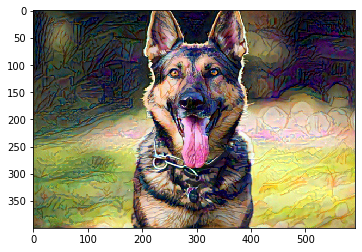

Total loss:  tensor(75485432., device='cuda:0', grad_fn=<AddBackward0>)


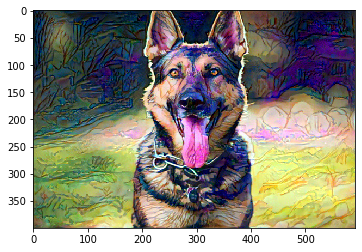

Total loss:  tensor(50308024., device='cuda:0', grad_fn=<AddBackward0>)


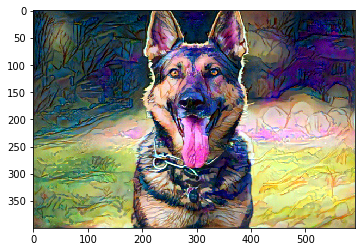

Total loss:  tensor(37868052., device='cuda:0', grad_fn=<AddBackward0>)


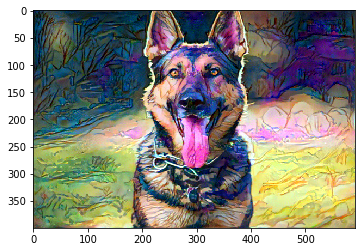

Total loss:  tensor(29937532., device='cuda:0', grad_fn=<AddBackward0>)


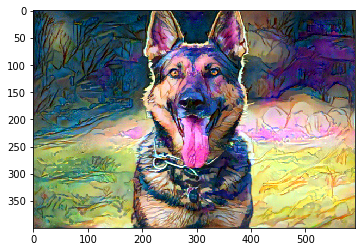

Total loss:  tensor(24163782., device='cuda:0', grad_fn=<AddBackward0>)


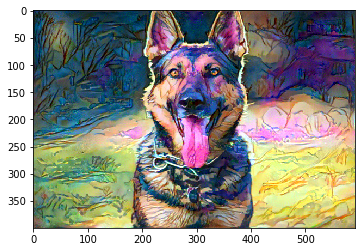

In [17]:
# updating the target and calculating the losses

show_every = 500
steps = 3000

optimizer = optim.Adam([target], lr=0.003)

for i in range(1, steps+1):
    
    target_features = get_features(target, vgg)
    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)
    
    
    style_loss = 0
    for layer in style_weights:
        target_feature = target_features[layer]
        _, d, h, w = target_feature.shape
        
        target_gram = gram_matrix(target_feature)
        
        style_gram = style_grams[layer]
        
        layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
        
        style_loss += layer_style_loss/ (d*h*w)
        

    total_loss = content_weight * content_loss + style_weight * style_loss
    
    
    # updating the target image
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    if i % show_every == 0:
        print('Total loss: ', total_loss)
        plt.imshow(im_convert(target))
        plt.show()